<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/4_Second_order_methods/A_8_Nonconvex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appendix A. Advanced First- and Second-Order Optimization Methods

# Newton's method, regularization, and non-convex functions

As we have seen because it is based on the second order Taylor series approximation, Newton's method is naturally inapplicable to minimizing generic non-convex functions properly.  This is because the second order approximation is a quadratic whose shape mirrors that of any non-convex portions of a function locally (i.e., where it is concave, flat, or has a saddle point), thus leading the method to climb towards local maxima or even diverge since the stationary points of such quadratics are maxima or saddle points (and not minima as we desire).  

In this Section we describe a common approach to ameliorate this particular issue which is conceptually simple, we have essentially already seen it before (albeit without the more in depth context we provide here): we use the adjusted Newton step detailed in the  Section 7.2, only we increase the value of $\epsilon$ substantially.  As we will see in this Section, in doing this we actually *convexify* the second order approximation making the adjusted Newton method step descend on non-convex functions.  When performed repeatedly at each step of adjusted Newton's method this procedure - an instance of what is more generally called *regularization* -  forces Newton's method to travel downwards and converge to a local minimum of a non-convex function.  

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone library subdirectory
if not Path('chapter_4_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/4_Second_order_methods/chapter_4_library
else:
    print('chapter_4_library already cloned!')

# clone videos
if not Path('chapter_4_videos').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/4_Second_order_methods/chapter_4_videos
else:
    print('chapter_4_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_4_library')
sys.path.append('./chapter_4_videos') 

# import section helper
import section_4_6_helpers

# video paths
video_path_1 = 'chapter_4_videos/animation_9.mp4'
video_path_2 = 'chapter_4_videos/animation_10.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_4_library already cloned!
chapter_4_videos already cloned!


## Turning up $\epsilon$ 

In the previous Section we learned how at the $k^{th}$ step of Newton's method we form the second order Taylor series centered at the current step $\mathbf{w}^{k-1}$

\begin{equation}
h(\mathbf{w}) = g(\mathbf{w}^{k-1}) + \nabla g(\mathbf{w}^{k-1})^T(\mathbf{w} - \mathbf{w}^{k-1}) + \frac{1}{2}(\mathbf{w} - \mathbf{w}^{k-1})^T \nabla^2 g\left(\mathbf{w}^{k-1}\right) (\mathbf{w} - \mathbf{w}^{k-1})
\end{equation}

and use the first order condition for unconstrained optimality to find a stationary point $\mathbf{w}^k$ of this quadratic, which is given algebraically as

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

Near the end of the previous Section we discussed how adding a very small positive value $\epsilon$ to the second derivative of a single-input function, or analogously a weighted identity matrix of the form $\epsilon \mathbf{I}_{N\times N}$ to the Hessian in the multi-input case, helps Newton's method avoid numerical problems in flat regions of a convex function.  The general adjusted Newton step took the form

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

We can actually interpret this as the stationary point of a slightly adjusted second order Taylor series approximation centered at $\mathbf{w}^{k-1}$.  This approximation takes the related form

\begin{equation}
h(\mathbf{w}) = g(\mathbf{w}^{k-1}) + \nabla g(\mathbf{w}^{k-1})^T(\mathbf{w} - \mathbf{w}^{k-1}) + \frac{1}{2}(\mathbf{w} - \mathbf{w}^{k-1})^T \nabla^2 g\left(\mathbf{w}^{k-1}\right) (\mathbf{w} - \mathbf{w}^{k-1}) + \frac{\epsilon}{2}\left\Vert \mathbf{w} - \mathbf{w}^{k-1} \right \Vert_2^2
\end{equation}

and the fact that our adjusted Newton step is a stationary point of it can be easily checked via the first order condition. 

What do we have here?  The first three terms (on the right hand side of the equality) still represent the second order Taylor series at $\mathbf{w}^{k-1}$, and to it we have added $\frac{\epsilon}{2}\left\Vert \mathbf{w} - \mathbf{w}^{k-1} \right \Vert_2^2$, a *convex* and perfectly symmetric quadratic centered at $\mathbf{w}^{k-1}$ with $N$ positive eigenvalues (each equal to $\frac{\epsilon}{2}$).  In other words: we have a sum of two quadratic functions.  When $\mathbf{w}^{k-1}$ is at a non-convex or flat portion of a function the first quadratic - the second order Taylor series - is likewise non-convex or flat: but the second one is *always* convex, and the larger $\epsilon$ is the greater its (upward) curvature.  This means that if we set $\epsilon$ larger we can *convexify the entire approximation*, forcing the stationary point we solve for to be a minimum and the direction in which we travel is one of guaranteed descent.

The idea of convexifying a function by adding a symmetric convex function to it is a general technique used in many branches of science and engineering, including machine learning/deep learning, for removing the undesirable trait(s) of the given function and is called *regularization*.  The convex function being added on is referred to as a *regularizer*, which in this case is the quadratic $\frac{1}{2}\left\Vert \mathbf{w} - \mathbf{w}^{k-1} \right \Vert_2^2$. The parameter $\epsilon$ in this context is referred to as the regularization parameter.  

#### <span style="color:#a50e3e;">Example 1. </span>   Regularizing a non-convex quadratic

Below we illustrate the regularization of a non-convex function

\begin{equation}
h_1(w_1,w_2) = w_1^2 - w_2^2
\end{equation}

using the convex regularizer

\begin{equation}
h_2(w_1,w_2) = w_1^2 + w_2^2
\end{equation}

In particular we show what the resulting sum $h_1 + \epsilon h_2$ looks like over a range of values for $\epsilon$.  In the plot below we show $h_1$ and $h_2$ in the left and middle panels respectively, with $h_1 + \epsilon h_2$ shown in the right panel.  Using the slider widget below the figure you can peruse various values for $\epsilon$ and see what the resulting sum looks like.  When the slider is all the way to the left $\epsilon = 0$, when all the way to the right $\epsilon = 2$.

Since $h_1$ is non-convex, and has a single stationary point with is a saddle point at the origin, the addition of $h_2$ pulls up its downward facing dimension.  Not surprisingly as $\epsilon$ is increased the shape of the sum is dictated more and more by $h_2$.

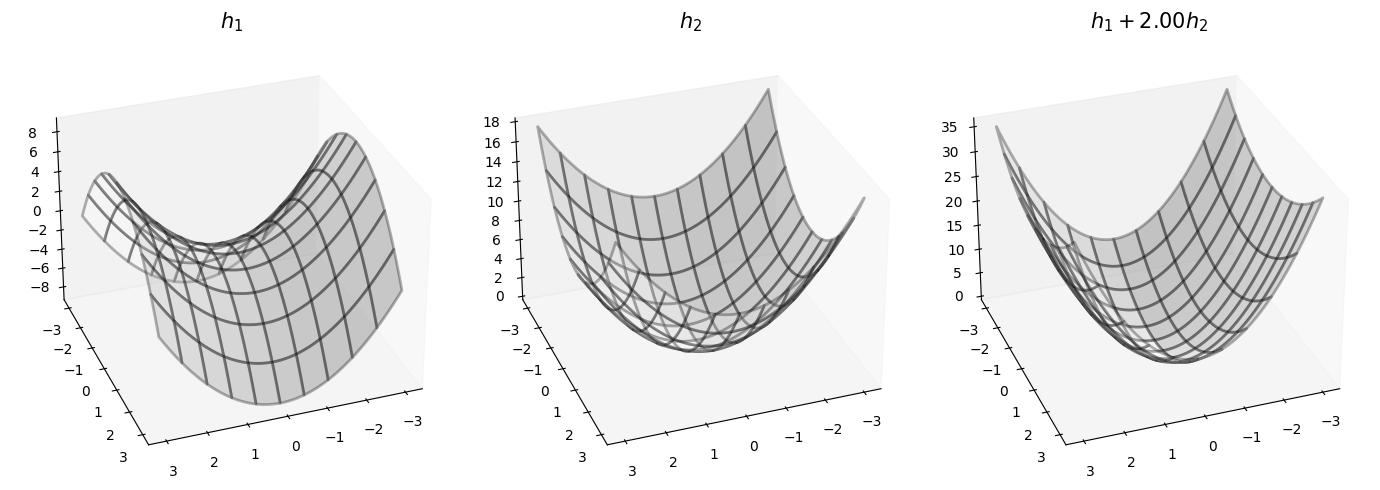

In [2]:
# what function should we play with?  Defined in the next line.
h1 = lambda w: w[0]**2 - w[1]**2
h2 = lambda w: w[0]**2 + w[1]**2

# create an instance of the visualizer with this function
demo = section_4_6_helpers.function_addition_visualizer()

# plot away
demo.draw_it(h1,h2,savepath = video_path_1,num_frames = 203,view = [30,70],epsmax = 2,set_axis = 'off',fps=20)

In [3]:
show_video(video_path_1, width=1000)

---

How high do we need to turn up $\epsilon$ in the regularized second order Taylor series approximation (when centered at a non-convex point) in order to make it convex?  We know from Section 5.3 that a quadratic function is convex if and only if it has all nonnegative eigenvalues.  With this in mind a simple analysis of the regularized quadratic quickly reveals the answer: *$\epsilon$ must be made larger then the magnitude of the smallest eigenvalue of $\nabla^2 g\left(\mathbf{w}^{k-1}\right)$  in order for the regularized second order quadratic to be convex*.  For a single input function this reduces to $\epsilon$ being larger in magnitude than value of the function's second derivative at $w^{k-1}$ if it is negative there.

> *$\epsilon$ must be made larger than the magnitude of the smallest eigenvalue of $\nabla^2 g\left(\mathbf{w}^{k-1}\right)$  in order for the regularized second order quadratic to be convex*.

This fact can be visually verified for the particular case of the previous example by moving the slider until $\epsilon$ is just greater than 1.  Here the regularized quadratic begins to take a convex shape, since in that case the smallest negative eigenvalue of $\nabla^2 g\left(\mathbf{w}^{k-1}\right)$ was $-1$. 

To see how the claim holds more generally first note that we can rewrite the regularized approximation combining the two quadratic terms into one as

\begin{equation}
h^{\,}(\mathbf{w}^{\,}) = g^{\,}(\mathbf{w}^{k-1}) + \nabla g^{\,}(\mathbf{w}^{k-1})^T(\mathbf{w}^{\,} - \mathbf{w}^{k-1}) + \frac{1}{2}(\mathbf{w}^{\,} - \mathbf{w}^{k-1})^T \left(\nabla^2 g^{\,}\left(\mathbf{w}^{k-1}\right) + \epsilon^{\,} \mathbf{I}_{N\times N}\right) (\mathbf{w}^{\,} - \mathbf{w}^{k-1})
\end{equation}

We know that, mathematically speaking, this quadratic will be convex if and only if the eigenvalues of the matrix generating it

\begin{equation}
\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}
\end{equation}

are all nonnegative. Denote $\nabla^2 g\left(\mathbf{w}^{k-1}\right) = \mathbf{V}\mathbf{D}\mathbf{V}^T$ as the eigen-decomposition of the Hessian at $\mathbf{w}^{k-1}$ (see Chapter 2 if this is unfamiliar), where in particular $\mathbf{D}$ is the $N\times N$ diagonal matrix of eigenvalues.  A slight re-writing of the above quadratic using this decomposition  

\begin{equation}
\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N} = \mathbf{V}\mathbf{D}\mathbf{V}^T + \epsilon \mathbf{I}_{N\times N} = \mathbf{V}\left(\mathbf{D} + \epsilon \mathbf{I}_{N\times N} \right) \mathbf{V}^T
\end{equation}

shows that $\epsilon$ must be set at larger than the magnitude of the smallest negative eigenvalue of $\nabla^2 g\left(\mathbf{w}^{k-1}\right)$ in order for all eigenvalues of the regularized quadratic to be nonnegative, and hence for the quadratic to be convex.

## From Newton's method to gradient descent

As we can see from the visualization in the previous example, adding a symmetric convex function to the second order quadratic we can bend it 'upwards', making the sum convex and the stationary point a minimum.  However unlike when we set $\epsilon$ to a very small positive value as a guard against numerical instability when applying Newton's method to convex functions as we did in Section 7.3, here convexifying the second order approximation at a point of non-convexity likely requires that we set $\epsilon$ to a comparatively large value.  Practically speaking this means that we will significantly disturb both the magnitude and direction of the Newton step, which of course we want to do at a point of non-convexity so long as the new direction/magnitude of the step leads to a lower point on the function.  But will addressing the symptom (non-convexity of the second order approximation) solve the natural failure of Newton's method climbing hills/diverging due to non-convexity?  In other words, does convexifying the second order approximation create a descent direction?  

*Yes, it does.*  In the final subsection we verify this fact more rigorously, but for the moment to get a gross sense of why this happens notice how when we turn up $\epsilon$ to a large number the direction we travel actually becomes the gradient descent direction at $\mathbf{w}^{k-1}$.

\begin{equation}
-\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1}) \approx  -\left( \epsilon \mathbf{I}_{N\times N} \right)^{-1}\nabla g(\mathbf{w}^{k-1}) = - \frac{1}{\epsilon}\nabla g(\mathbf{w}^{k-1})
\end{equation}

That is, when $\epsilon$ is large the direction we travel when taking the adjusted Newton step becomes the gradient descent direction, albeit with a very small magnitude.  

This simple argument also illustrates a general need for the use of a steplength parameter $\alpha$ to control the length of each adjusted Newton step when applied to a non-convex function, since in turning up $\epsilon$ we lose the 'natural' magnitude of the pure Newton step.  Thus our adjusted Newton step at $\mathbf{w}^{k-1}$ is better written as

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

When applied to non-convex functions, the steplength parameter $\alpha$ must be chosen by one of the same approaches discussed for gradient descent (i.e., trial and error or backtracking line search).

>  When applied to non-convex functions a steplength parameter $\alpha$ should be used to control the length of each adjusted Newton step giving the update $\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1}).$ 

#### <span style="color:#a50e3e;">Example 2. </span>   Regularized Newton's method animated for a single-input function

Below we illustrate at most five adjusted Newton steps with $\alpha = 1$ applied to the function

$$
g(w) = 2-e^{-w^2}
$$

over a range of values for $\epsilon$.  For a given $\epsilon$ value the function, all steps are shown colored from green (the first step) to red (the final step), as well as the regularized second order approximation at each step (each colored like its respective step) are shown in the left panel.  In the right panel we show the corresponding function evaluation plot of all steps taken.

As you move the slider from left to right the value of $\epsilon$ increases in the range from 0 to 4 is chosen and a run (with this $\epsilon$) of the adjusted Newton's method is shown, each time initialized at the point $w = 1.2$.

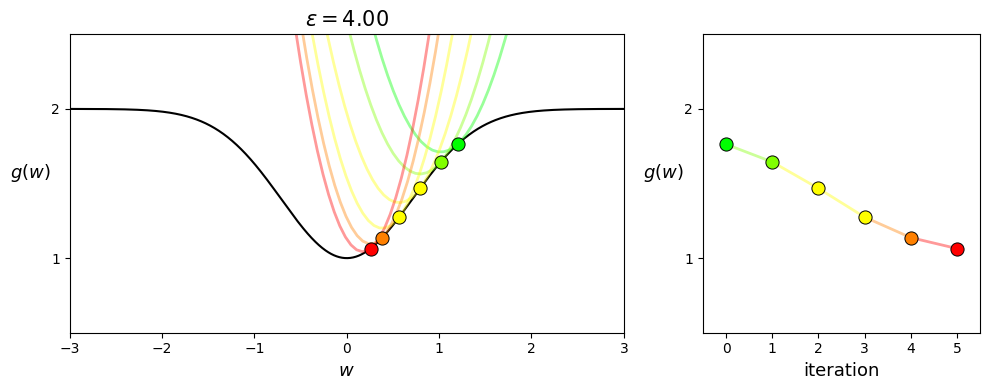

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: 2 - np.exp(-w**2)

# create an instance of the visualizer with this function
demo = section_4_6_helpers.regularized_newton_visualizer(g = g)

# run the visualizer for our chosen input function, initial point, and step length alpha
epsilon_range = np.linspace(0,4,200)
demo.animate_it(epsilon_range,savepath = video_path_2, w_init = 1.2, max_its = 5,fps=10)

In [5]:
show_video(video_path_2, width=1000)

## Implementation discussion

We now know that - mathematically speaking - in order to convexify the second order approximation at a point $\mathbf{w}^{k-1}$ the value of $\epsilon$ must be chosen greater in magnitude than the smallest negative eigenvalue of the Hessian evaluated there.  In theory then at each iteration we could simply compute the smallest negative eigenvalue of $\nabla^2g\left(\mathbf{w}^k\right)$ then set $\epsilon$ equal to this plus some small positive value (e.g., $10^{-7}$).  The practical reality of the situation however is that computing the smallest eigenvalue of an $N\times N$ matrix - using e.g., the [power method](https://en.wikipedia.org/wiki/Power_iteration) - is a computationally expensive task (particularly as $N$ increases).  Thus all manner of approximation/guess-and-check schemes are employed in practice to estimate a reasonable value for $\epsilon$ - one that convexifies the second order quadratic - as inexpensively as possible.  For example, setting the $\epsilon$ fixed for all iterations, and tuning its value by trial and error, is an often used strategy.  Combined with the need to determine proper steplength parameter $\alpha$ at each step - which too may be set by trial and error - successful application of adjusted Newton's method to the minimization of non-convex functions typically requires substantial engineering effort.

## Appendix calculations

Here we rigorously verify that when $\epsilon$ is set large enough to convexify the regularized second order approximation that the corresponding adjusted Newton step is in a descent direction.

With $\epsilon$ set large enough so that the regularized second order quadratic is convex, to verify that the above step produces descent (for some value of $\alpha$) we can follow an argument very similar to the one given for gradient descent and backtracking linesearch / conservative steplength values for gradient descent.  That is, by design the regularized quadratic $h$ takes on the same value as $g$ at $\mathbf{w}^{k-1}$, i.e., $g\left(\mathbf{w}^{k-1}\right) = h\left(\mathbf{w}^{k-1}\right)$.  Since $h$ is convex with curvature along each input dimension that is equal to or than greater than the local curvature of $g$ at $\mathbf{w}^{k-1}$ it follows that for a small enough value of $\alpha$ the evaluation of $h$ at

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

lies above $g$, i.e., $g\left(\mathbf{w}^{k}\right) < h\left(\mathbf{w}^{k}\right)$. 

Simplifying the form of $h\left(\mathbf{w}^{k} \right)$ we can see that

\begin{equation}
h^{\,}(\mathbf{w}^{k}) = g^{\,}\left(\mathbf{w}^{k-1}\right) - \frac{\alpha}{2}\nabla g^{\,}\left(\mathbf{w}^{k-1}\right)^T\left(\nabla^2 g\left(\mathbf{w}^{k-1}\right) + \epsilon \mathbf{I}_{N\times N}\right)^{-1} \nabla g^{\,}(\mathbf{w}^{k-1})
\end{equation}

Since $\nabla^2 g\left(\mathbf{w}^{k-1}\right) + \epsilon \mathbf{I}_{N\times N}$ has all positive eigenvalues it follows that $\nabla g^{\,}(\mathbf{w}^{k-1})^T\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1} \nabla g^{\,}(\mathbf{w}^{k-1}) > 0$ or - in other words - that 

\begin{equation}
h^{\,}(\mathbf{w}^{k}) = g^{\,}\left(\mathbf{w}^{k-1}\right) - \frac{\alpha}{2}\nabla g^{\,}\left(\mathbf{w}^{k-1}\right)^T\left(\nabla^2 g\left(\mathbf{w}^{k-1}\right) + \epsilon \mathbf{I}_{N\times N}\right)^{-1} \nabla g^{\,}(\mathbf{w}^{k-1}) < g^{\,}\left(\mathbf{w}^{k-1}\right)
\end{equation}

and so for small enough $\alpha$

\begin{equation}
 g^{\,}\left(\mathbf{w}^{k}\right)  <  g^{\,}\left(\mathbf{w}^{k-1}\right) 
\end{equation}